In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import re

In [5]:
dat = pd.read_csv("kiche/TRAIN.tsv", sep="\t", encoding="UTF-8", header=None)
dev = pd.read_csv("kiche/DEV.tsv", sep="\t", encoding="UTF-8", header=None)

In [4]:
dat.head(10)

,0,1
0,Ri numam xkamik are taq kʼo jumuchʼ lajuj ujun...,Ri nu>mam x>kamik are taq kʼo jumuchʼ lajuj u>...
1,Nojel qʼij ri a Tiʼx kuyuqʼuj le taq awaj jela...,Nojel qʼij ri a Tiʼx k>u>yuqʼuj le taq awaj je...
2,Kateʼbʼin .,K>at>eʼ>bʼin .
3,Entonses are kʼwaʼ le kawaj kinbʼij pan in .,Entonses are kʼ>waʼ le k>aw>aj k>in>bʼij pan in .
4,Nim raqan le cheʼ .,Nim r>aqan le cheʼ .
5,Chweʼq kinchakun pa qʼij chi chaqʼabʼ .,Chweʼq k>in>chakun pa qʼij chi chaqʼabʼ .
6,"Jeʼ , kimbʼek .","Jeʼ , k>im>bʼe>k ."
7,"Ri imul xuchʼij taj , xkanaj pa bʼe , rumal ri...","Ri imul x>u>chʼij taj , x>kanaj pa bʼe , r>uma..."
8,Ri ukis akʼ utz kyaʼik chi uxeʼ ri tikoʼn .,Ri u>kis akʼ utz k>yaʼ>ik chi u>xeʼ ri tikoʼn .
9,Chweʼq kinbʼe pa nim tinamit .,Chweʼq k>in>bʼe pa nim tinamit .


In [305]:
dev.head(10)

,0,1
0,Chi uxeʼ ri mexa kʼo wi ri chʼo .,Chi u>xeʼ ri mexa kʼo wi ri chʼo .
1,Na xinnabʼej ta chutasik qakʼolibʼal .,Na x>in>nabʼej ta ch>u>tas>ik qa>kʼolibʼal .
2,Xubʼij che : - jas xabʼano Tintin ?,X>u>bʼij ch>e : - jas x>a>bʼan>o Tintin ?
3,Chanim in kʼo pa mokokil .,Chanim in kʼo pa mokokil .
4,Xalax pa ri Kaweq .,X>alax pa ri Kaweq .
5,"Xpax ri ujukubʼ , ri kej .","X>pax ri u>jukubʼ , ri kej ."
6,Je la leʼ ri nupwiʼ .,Je la leʼ ri nu>pwiʼ .
7,Kʼo pa ja tijobʼal ri wikaqʼ .,Kʼo pa ja tijobʼal ri w>ikaqʼ .
8,Xinalax pa jun qʼij ubʼiʼ wajxaqibʼ Noʼj .,X>in>alax pa jun qʼij u>bʼiʼ wajxaqibʼ Noʼj .
9,Aʼre xetoʼw alaq .,Aʼre x>e>toʼ>w alaq .


In [6]:
def tokenizer(inp: object):
    """tokenize a pandas column of strings and add begnning and end markers
    :param inp: pandas column
    
    >>>tokenizer(df["foo"])
    [["^foo$", "^bar$"], ["^baz$"]]
    """
    words = [("^" + i + "$") for i in inp]
    for i in range(len(words)):
        words[i] = re.sub(" ", "$ ^", words[i])
        words[i] = words[i].split(' ')
    return words

In [9]:
def preprocess(inp: list):
    """turns list of lists of lexeme strings into a list of lists of lists of phoneme feature dictionaries
    :param inp: list to process
    
    >>> preprocess([["^abc$"]])
    """
    try:
        assert type(inp) == list
        assert type(inp[0]) == list
        assert type(inp[0][0]) == str
        assert inp[0][0][0]
        assert type(inp[0][0][0]) == str
    except:
        raise TypeError("input needs to be a list of lists of strings")
    stats = []
    vowels = {"u", "i", "a", "o", "e", "ʼ"}
    velar = {"k", "x", "q"}
    for sent in inp:
        snt = []
        for index in range(len(sent)):
            word = sent[index]
            true_len = len(word) - 2
            if true_len <= 1:
                continue
            wrd = []
            for i in range(len(word))[1:true_len]:
                dic = {}
                dic["beg"]=i
                dic["sym"]=word[i]
                if dic["sym"] in vowels:
                    dic["vow"] = 1
                else:
                    dic["vow"] = 0
                if dic["sym"] in velar:
                    dic["vel"] = 1
                else:
                    dic["vel"] = 0
                dic["pos"] = index
                dic["end"]=true_len - dic["beg"]
                dic["len"]=true_len
                dic["mult"]=np.log1p(dic["beg"] * dic["end"])
                dic["add"]=dic["len"] / dic["mult"]
                dic["relBeg"]=dic["beg"] / dic["len"]
                dic["relEnd"]=dic["end"] / dic["len"]
                dic["logBeg"]=np.log1p(dic["relBeg"])
                dic["logEnd"]=np.log1p(dic["relEnd"])
                dic["prev"]=word[i-1]
                if dic["prev"] in vowels:
                    dic["prevV"] = 1
                else:
                    dic["prevV"] = 0
                dic["next"]=word[i+1]
                if dic["next"] in vowels:
                    dic["nextV"] = 1
                else:
                    dic["nextV"] = 0
                dic["next2"]=word[i+2]
                dic["nextBi"]=dic["next"] + dic["next2"]
                dic["prevBi"]=dic["prev"] + dic["sym"]
                dic["curBi"]=dic["sym"] + dic["next"]
                dic["prevTri"]=dic["prev"] + dic["curBi"]
                dic["curTri"]=dic["sym"] + dic["nextBi"]
                if "$" in dic["nextBi"]:
                    dic["nextTri"]=dic["nextBi"]+"$"
                else:
                    dic["nextTri"]=dic["nextBi"]+word[i+3]
                dic["curQuat"]=dic["prev"] + dic["curTri"]
                wrd.append(dic)
            snt.append(wrd)
        stats.append(snt)
    return stats

In [7]:
words_1 = tokenizer(dat.iloc[:,0])
tst = tokenizer(dev.iloc[:,0])

In [10]:
tst_stats = preprocess(tst)
sym_stats = preprocess(words_1)

In [16]:
def tyndices(inp: str):
    tyndex = 0
    ret = set()
    for i in range(len(inp)):
        if inp[i] == ">":
            ret.add(tyndex - 1)
        else:
            tyndex += 1
    return ret

In [12]:
def sent_process(inp: list, ind: int):
    tynd = 0
    for word_ind in range(len(inp)):
        wrd = inp[word_ind][:-1]
#         wrd = inp[word_ind]
        if len(wrd) == 0:
            continue
        hlp = tyndices(wrd)
#         print(tynd)
#         print(len(sym_stats[ind]))
#         print(sym_stats[ind][tynd])
        appendix(sym_stats[ind][tynd], hlp)
        tynd += 1

In [13]:
def appendix(inp: list, tynd: set):
    for index in range(len(inp)):
        if index in tynd:
            inp[index]["bound"] = 1
        else:
            inp[index]["bound"] = 0

In [14]:
def to_sound_list(inp: list): 
    all_sents = []
    for i in inp:
        all_sents += i
    all_words = []
    for i in all_sents:
        all_words += i
    return all_words

In [17]:
words2 = [i.split(" ") for i in dat.iloc[:,1]]
for ind, sent in enumerate(words2):
    sent_process(sent, ind)

In [18]:
neues = pd.DataFrame.from_dict(to_sound_list(sym_stats))
all_tst = pd.DataFrame.from_dict(to_sound_list(tst_stats))

In [19]:
neues.tail(10)

,beg,sym,vow,vel,pos,end,len,mult,add,relBeg,...,nextV,next2,nextBi,prevBi,curBi,prevTri,curTri,nextTri,curQuat,bound
28336,1,r,0,0,1,1,2,0.693147,2.885390,0.500000,...,1,$,i$,^r,ri,^ri,ri$,i$$,^ri$,0
28337,1,n,0,0,2,4,5,1.609438,3.106675,0.200000,...,1,p,up,^n,nu,^nu,nup,upa,^nup,0
28338,2,u,1,0,2,3,5,1.945910,2.569492,0.400000,...,0,a,pa,nu,up,nup,upa,pam,nupa,1
28339,3,p,0,0,2,2,5,1.945910,2.569492,0.600000,...,1,m,am,up,pa,upa,pam,am$,upam,0
28340,4,a,1,0,2,1,5,1.609438,3.106675,0.800000,...,0,$,m$,pa,am,pam,am$,m$$,pam$,0
28341,1,X,0,0,0,5,6,1.791759,3.348664,0.166667,...,1,n,in,^X,Xi,^Xi,Xin,inb,^Xin,1
28342,2,i,1,0,0,4,6,2.197225,2.730718,0.333333,...,0,b,nb,Xi,in,Xin,inb,nbʼ,Xinb,0
28343,3,n,0,0,0,3,6,2.302585,2.605767,0.500000,...,0,ʼ,bʼ,in,nb,inb,nbʼ,bʼe,inbʼ,1
28344,4,b,0,0,0,2,6,2.197225,2.730718,0.666667,...,1,e,ʼe,nb,bʼ,nbʼ,bʼe,ʼe$,nbʼe,0
28345,5,ʼ,1,0,0,1,6,1.791759,3.348664,0.833333,...,1,$,e$,bʼ,ʼe,bʼe,ʼe$,e$$,bʼe$,0


In [20]:
oneh = OneHotEncoder()
temp = neues.iloc[:,:-1]
common = pd.concat([temp, all_tst], axis=0)
oneh.fit(common[["sym", "prev", "next", \
                 "next2", "nextBi", "nextTri", \
                 "prevBi", "curBi", "prevTri", \
                 "curTri", "curQuat"]])

trans = oneh.transform(neues[["sym", "prev", "next", \
                              "next2", "nextBi", "nextTri", \
                              "prevBi", "curBi", "prevTri", \
                              "curTri", "curQuat"]])

tr_test = oneh.transform(all_tst[["sym", "prev", "next", \
                                  "next2", "nextBi", "nextTri", \
                                  "prevBi", "curBi", "prevTri", \
                                  "curTri", "curQuat"]])

coo1 = coo_matrix(neues[["beg", "end", "len", \
                         "vow", "vel", "pos", \
                         "mult", "relBeg", "relEnd", \
                         "logBeg", "logEnd", "add"]].to_numpy())

coo2 = coo_matrix(all_tst[["beg", "end", "len", \
                           "vow", "vel", "pos", \
                           "mult", "relBeg", "relEnd", \
                           "logBeg", "logEnd", "add"]].to_numpy())

alles = hstack([coo1, trans])
tst_matrix = hstack([coo2, tr_test])


In [21]:
y = neues["bound"].to_numpy(dtype=np.dtype(int))
x_train, x_test, y_train, y_test = train_test_split(alles, y, test_size=0.10)

In [22]:
logreg = LogisticRegression(C=1, class_weight="balanced", max_iter=150, n_jobs=2)
logreg.fit(x_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=150, n_jobs=2)

In [492]:
y_pred = logreg.predict(x_test)

In [493]:
target_names = ["no_bound", "is_bound"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    no_bound       0.98      0.95      0.97      2356
    is_bound       0.79      0.93      0.85       479

    accuracy                           0.95      2835
   macro avg       0.89      0.94      0.91      2835
weighted avg       0.95      0.95      0.95      2835



In [465]:
scores = cross_validate(logreg, alles, y, cv=5, scoring=("f1", "f1_weighted"), return_train_score=False)
for i in scores.items():
    print(str(i) + "\n")

('fit_time', array([2.12908387, 0.96810913, 0.94753456, 0.93192744, 0.92413592]))

('score_time', array([0.00700307, 0.00499964, 0.00500226, 0.00500131, 0.00499988]))

('test_f1', array([0.86218735, 0.86550868, 0.8641604 , 0.85928144, 0.85121107]))

('test_f1_weighted', array([0.95206347, 0.95358159, 0.95339283, 0.95158131, 0.94849653]))



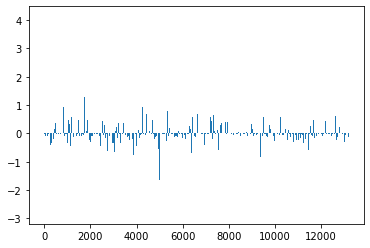

In [466]:
importance = logreg.coef_
plt.bar([x for x in range(len(importance[0]))], importance[0])
plt.show()

In [531]:
def process_string(inp: str, encoder: object, model: object):
    """return the predicted version of the string
    :param inp: string to process
    :param encoder: one-hot encoder conditioned on the training set
    :param model: a linear regression model conditioned on the training set
    
    >>> process_string("acab")
    "ac>ab"
    """
    if not type(inp) == str:
        raise TypeError("only accepts strings as input")
    delimiters = re.findall(r"( [a-bA-B][.,?:\- ]+|[^a-zA-Zʼ]+)", inp)
    inp_new = "^" + re.sub(" ", "$ ^", inp) + "$"
    inp_list = [inp_new.split(" ")]
    inp_stats = preprocess(inp_list)
    stats_df = pd.DataFrame.from_dict(to_sound_list(inp_stats))
    discrete = encoder.transform(stats_df[["sym", "prev", "next", \
                              "next2", "nextBi", "nextTri", \
                              "prevBi", "curBi", "prevTri", \
                              "curTri", "curQuat"]])
    numeric = coo_matrix(stats_df[["beg", "end", "len", \
                         "vow", "vel", "pos", \
                         "mult", "relBeg", "relEnd", \
                         "logBeg", "logEnd", "add"]].to_numpy())
    features = hstack([numeric, discrete])
    labels = model.predict(features)
    reusable_line = ""
    output_list = []
    for ind in range(labels.shape[0]):
        line = stats_df.loc[ind, ["sym", "next", "nextBi"]]
        reusable_line += line["sym"]
        if labels[ind] == 1:
            reusable_line += ">"
        if "$" in line["nextBi"]:
            reusable_line += line["next"]
            output_list.append(reusable_line)
            reusable_line = ""
    if len(output_list) == 1 or len(delimiters) == 0:
        return output_list[0]
    if len(output_list) != len(delimiters):
        raise Exception("inconsistent number of words and delimiters")
    output_list[-1] += delimiters[-1]
    output_string = ""
    for index in range(len(delimiters))[:-1]:
        output_string += output_list[index]
        output_string += delimiters[index]
    output_string += output_list[-1]
    return output_string

In [532]:
process_string("Chi uxeʼ ri mexa kʼo wi ri chʼo .", oneh, logreg)

'Chi u>xeʼ ri mexa kʼo wi ri chʼo .'

In [533]:
reserve = dev.copy()

In [534]:
for index, line in enumerate(reserve[0]):
    print(line)
    reserve.iloc[index, 1] = process_string(line, oneh, logreg)

Chi uxeʼ ri mexa kʼo wi ri chʼo .
Na xinnabʼej ta chutasik qakʼolibʼal .
Xubʼij che : - jas xabʼano Tintin ?
Chanim in kʼo pa mokokil .
Xalax pa ri Kaweq .
Xpax ri ujukubʼ , ri kej .
Je la leʼ ri nupwiʼ .
Kʼo pa ja tijobʼal ri wikaqʼ .
Xinalax pa jun qʼij ubʼiʼ wajxaqibʼ Noʼj .
Aʼre xetoʼw alaq .
Aʼre xetoʼw alaq .
Xintik qʼax chi uwach ri ja .
Aninaq kwaj ri nuwa .
Xqarqat ri akʼ are chiʼ xsikʼowik .
Karapinik xutzukuj chi jun awaj .
Oj kʼo pa le roʼch le a Wel .
We man je kabʼan chike , kabʼison le rajaw tuj .
Xnaʼtaj ri akʼal chwe .
Kawaj kimbʼe pa tinamit .
Chaqiʼj chik ri chaj .
Xinloqʼ jun kʼakʼ ukaʼ ri numiʼal .
Jawi kʼo wi le wuj re le qatijonik ?
Noʼjim ukemik le pas awumal .
Noʼjim ukemik le pas awumal .
Nim ubʼaqʼ ri tulul .


In [537]:
reserve.to_csv("out.tsv", sep="\t", header=False, index=False)

In [482]:
all_tst

,beg,sym,vow,vel,pos,end,len,mult,add,relBeg,...,next,nextV,next2,nextBi,prevBi,curBi,prevTri,curTri,nextTri,curQuat
0,1,C,0,0,0,2,3,1.098612,2.730718,0.333333,...,h,0,i,hi,^C,Ch,^Ch,Chi,hi$,^Chi
1,2,h,0,0,0,1,3,1.098612,2.730718,0.666667,...,i,1,$,i$,Ch,hi,Chi,hi$,i$$,Chi$
2,1,u,1,0,1,3,4,1.386294,2.885390,0.250000,...,x,0,e,xe,^u,ux,^ux,uxe,xeʼ,^uxe
3,2,x,0,1,1,2,4,1.609438,2.485340,0.500000,...,e,1,ʼ,eʼ,ux,xe,uxe,xeʼ,eʼ$,uxeʼ
4,3,e,1,0,1,1,4,1.386294,2.885390,0.750000,...,ʼ,1,$,ʼ$,xe,eʼ,xeʼ,eʼ$,ʼ$$,xeʼ$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,1,r,0,0,2,1,2,0.693147,2.885390,0.500000,...,i,1,$,i$,^r,ri,^ri,ri$,i$$,^ri$
416,1,t,0,0,3,4,5,1.609438,3.106675,0.200000,...,u,1,l,ul,^t,tu,^tu,tul,ulu,^tul
417,2,u,1,0,3,3,5,1.945910,2.569492,0.400000,...,l,0,u,lu,tu,ul,tul,ulu,lul,tulu
418,3,l,0,0,3,2,5,1.945910,2.569492,0.600000,...,u,1,l,ul,ul,lu,ulu,lul,ul$,ulul


In [467]:
pred = logreg.predict(tst_matrix)

In [ ]:
# tst_string = str()
# for ind in range(pred.shape[0]):
#     line = all_tst.loc[ind, ["sym", "next", "nextBi"]]
#     tst_string += line["sym"]
#     if pred[ind] == 1:
#         tst_string += ">"
#     if "$" in line["nextBi"]:
#         tst_string += (line["next"] + "\n")
# print(tst_string)

In [269]:
# sym_stats = []
# vowels = {"u", "i", "a", "o", "e", "ʼ"}
# velar = {"k", "x", "q"}
# for sent in words_1:
#     snt = []
# #     for word in sent:
#     for index in range(len(sent)):
#         word = sent[index]
#         true_len = len(word) - 2
#         if true_len <= 1:
#             continue
#         wrd = []
#         num_vow = len(re.findall(r"[aouei]", word))
#         for i in range(len(word))[1:len(word)-2]:
#             dic = {}
#             dic["sym"]=word[i]
#             dic["beg"]=i
#             if dic["sym"] in vowels:
#                 dic["vow"] = 1
#             else:
#                 dic["vow"] = 0
#             if dic["sym"] in velar:
#                 dic["vel"] = 1
#             else:
#                 dic["vel"] = 0
#             dic["pos"] = index
#             dic["end"]=true_len - dic["beg"]
#             dic["len"]= true_len
#             dic["nSyl"]=num_vow
#             dic["prev"]=word[i-1]
#             if dic["prev"] in vowels:
#                 dic["prevV"] = 1
#             else:
#                 dic["prevV"] = 0
#             dic["next"]=word[i+1]
#             if dic["next"] in vowels:
#                 dic["nextV"] = 1
#             else:
#                 dic["nextV"] = 0
#             dic["next2"]=word[i+2]
#             dic["nextBi"]=dic["next"] + dic["next2"]
#             wrd.append(dic)
#         snt.append(wrd)
#     sym_stats.append(snt)